In [1]:
#!/usr/bin/env python3
# 

import argparse
import numpy as np
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt

from fealpy.functionspace import LagrangeFiniteElementSpace
from fealpy.boundarycondition import NeumannBC 
from fealpy.tools.show import showmultirate
from fealpy.tools.show import show_error_table

## 参数解析
parser = argparse.ArgumentParser(description=
        """
        单纯形网格（三角形、四面体）网格上任意次有限元方法求解 Poisson 方程
        边界条件为纯 Neumann 条件
        """)

parser.add_argument('--degree',
        default=1, type=int,
        help='Lagrange 有限元空间的次数, 默认为 1 次.')

parser.add_argument('--GD',
        default=2, type=int,
        help='模型问题的维数, 默认求解 2 维问题.')

parser.add_argument('--nrefine',
        default=4, type=int,
        help='初始网格加密的次数, 默认初始加密 4 次.')

parser.add_argument('--maxit',
        default=4, type=int,
        help='默认网格加密求解的次数, 默认加密求解 4 次')

args = parser.parse_args()

degree = args.degree
GD = args.GD
nrefine = args.nrefine
maxit = args.maxit

if GD == 2:
    from fealpy.pde.poisson_2d import CosCosData as PDE
elif GD == 3:
    from fealpy.pde.poisson_3d import CosCosCosData as PDE

pde = PDE()
mesh = pde.init_mesh(n=nrefine)

errorType = ['$|| u - u_h||_{\Omega,0}$',
             '$||\\nabla u - \\nabla u_h||_{\Omega, 0}$'
             ]
errorMatrix = np.zeros((2, maxit), dtype=np.float64)
NDof = np.zeros(maxit, dtype=np.float64)

for i in range(maxit):
    space = LagrangeFiniteElementSpace(mesh, p=degree)
    NDof[i] = space.number_of_global_dofs()

    uh = space.function()
    A = space.stiff_matrix()
    F = space.source_vector(pde.source)
    bc = NeumannBC(space, pde.neumann) 

    # Here is the case for pure Neumann bc, we also need modify A
    A, F = bc.apply(F, A=A) 
    uh[:] = spsolve(A, F)[:-1] # we add a addtional dof

    errorMatrix[0, i] = space.integralalg.error(pde.solution, uh)
    errorMatrix[1, i] = space.integralalg.error(pde.gradient, uh.grad_value)

    if i < maxit-1:
        mesh.uniform_refine()


if GD == 2:
    uh.add_plot(plt, cmap='rainbow')
elif GD == 3:
    print('The 3d function plot is not been implemented!')

showmultirate(plt, 0, NDof, errorMatrix,  errorType, propsize=20)
show_error_table(NDof, errorType, errorMatrix)

plt.show()


usage: ipykernel_launcher.py [-h] [--degree DEGREE] [--GD GD]
                             [--nrefine NREFINE] [--maxit MAXIT]
ipykernel_launcher.py: error: unrecognized arguments: --ip=127.0.0.1 --stdin=9008 --control=9006 --hb=9005 --Session.signature_scheme="hmac-sha256" --Session.key=b"06ee413a-72ee-41d6-b70f-91b2e070ef18" --shell=9007 --transport="tcp" --iopub=9009 --f=c:\Users\18120\AppData\Roaming\jupyter\runtime\kernel-v2-30016VBFuD4r6ry2G.json


SystemExit: 2

C:\Users\18120\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py:3468: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


run boxmesh2d with time: 0.007713000000009629
run serial_construct_matrix with time: 0.05963930000000062


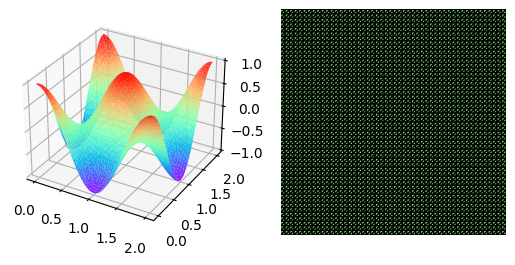

In [1]:
from fealpy.pde.poisson_2d import CosCosData # 导入二维 Poisson 模型实例
pde = CosCosData() # 创建 pde 模型对象

from fealpy.mesh import MeshFactory as MF # 导入网格工厂模块
domain = [0, 2, 0, 2]
mesh = MF.boxmesh2d(domain, nx=50, ny=50, meshtype='tri')

# 导入 Lagrange 有限元空间
from fealpy.functionspace import LagrangeFiniteElementSpace 
space = LagrangeFiniteElementSpace(mesh, p=1)  # 线性元空间

# 导入 Dirichlet 边界处理
from fealpy.boundarycondition import DirichletBC 
bc = DirichletBC(space, pde.dirichlet) # 创建 Dirichlet 边界条件处理对象

uh = space.function() # 创建有限元函数对象
A = space.stiff_matrix() # 组装刚度矩阵对象
F = space.source_vector(pde.source) # 组装右端向量对象
A, F = bc.apply(A, F, uh) # 应用 Dirichlet 边界条件

# 导入稀疏线性代数系统求解函数
from scipy.sparse.linalg import spsolve
uh[:] = spsolve(A, F)

L2Error = space.integralalg.error(pde.solution, uh)
H1Error = space.integralalg.error(pde.gradient, uh.grad_value)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
axes = fig.add_subplot(1, 2, 1, projection='3d')
uh.add_plot(axes, cmap='rainbow')
axes = fig.add_subplot(1, 2, 2)
mesh.add_plot(axes)